In [1]:
import os
import glob
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, model_selection, naive_bayes, \
    metrics, base
%matplotlib inline

In [2]:
data_dir = os.path.join("datasets", "spam_emails")
spam_dir = os.path.join(data_dir, "spam")
hardham_dir = os.path.join(data_dir, "hard_ham")
easyham_dir = os.path.join(data_dir, "easy_ham")

In [3]:
acc = {
    "spam": {
        "datadirs": [spam_dir],
        "text_accumulator": [],
        "response": 1
    },
    "ham": {
        "datadirs": [hardham_dir, easyham_dir],
        "text_accumulator": [],
        "response": 0
    }
}
undecoded = {"spam": [], "ham": []}

for datatype, container in acc.items():
    for ddir in container["datadirs"]:
        filenames = glob.glob(os.path.join(ddir, "*"))
        for i, filename in enumerate(filenames):
            try:
                with open(filename, "r", encoding="ascii", errors="surrogateescape") as f_obj:
                    lines = f_obj.readlines()
                    txt = ''.join(lines)
                    txt = ' '.join(txt.split())
            except UnicodeDecodeError:
                try:
                    with open(filename, "rb") as f_obj:
                        lines = f_obj.readlines()
                        lines = [s.decode('windows-1252') for s in lines]
                        txt = ''.join(lines)
                        txt = ' '.join(txt.split())
                except Exception as e:
                    undecoded[datatype].append(i)
            container["text_accumulator"].append(txt)

In [4]:
all_emails = acc["spam"]["text_accumulator"] + acc["ham"]["text_accumulator"]
targets = [1] * len(acc["spam"]["text_accumulator"]) + [0] * len(acc["ham"]["text_accumulator"])

In [5]:
test_size = 0.2

stratshuf = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=test_size)
train_ix, test_ix = next(stratshuf.split(all_emails, targets))

X_train = [all_emails[ix] for ix in train_ix]
y_train = [targets[ix] for ix in train_ix]
X_test = [all_emails[ix] for ix in test_ix]
y_test = [targets[ix] for ix in test_ix]

vec = feature_extraction.text.CountVectorizer()
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
nb_clf = naive_bayes.MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
y_pred = nb_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy is {round(accuracy*100, 2)}%")

Accuracy is 98.34%


In [9]:
probas = nb_clf.predict_proba(X_test)[:, 1]

In [10]:
true_classes = y_test
precisions, recalls, threshs = metrics.precision_recall_curve(true_classes, probas)

In [11]:
def plot_pr_curve(prec, rcll, thsh):
    plt.plot(thsh, prec[:-1], 'b--', label="Precision")
    plt.plot(thsh, rcll[:-1], 'g--', label="Recall")
    plt.legend()
    plt.show();

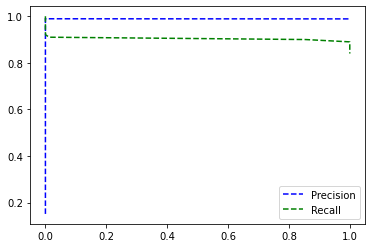

In [12]:
plot_pr_curve(precisions, recalls, threshs)

In [13]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs Recall")
    plt.show();

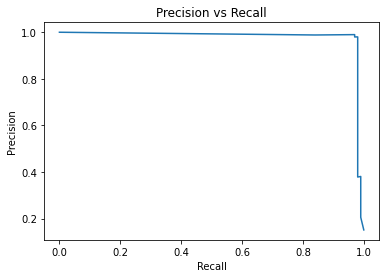

In [14]:
plot_precision_vs_recall(precisions, recalls)

In [15]:
fpr, tpr, thresh = metrics.roc_curve(y_test, probas)

In [16]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", linewidth=0.75)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.show();

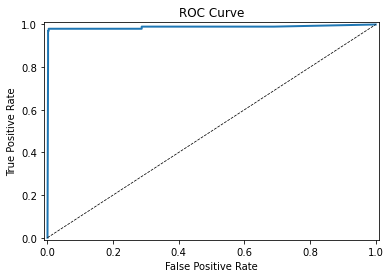

In [17]:
plot_roc(fpr, tpr)